In [1]:
import os
import pandas as pd
import sys
sys.path.insert(0, '/home/jupyter/')
from hourly_pollution_prediction.process_and_join.bbox import * 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
#for image inpainting
from skimage import data
from skimage.morphology import disk, binary_dilation
from skimage.restoration import inpaint
import cv2 as cv
import xesmf as xe
import geopandas as gpd
import rioxarray
from rioxarray.merge import merge_arrays
from pathlib import Path


In [3]:
df = pd.read_csv("../../data/tempo_data/no2_tempo_files_df.csv")

timestamps_dt = pd.to_datetime(df['timestamp_ct'])
unique_months = timestamps_dt.dt.to_period('M').unique()

# Compare to a Period object, not a string
unique_months = [month for month in unique_months if month != pd.Period('2025-06', freq='M')]

In [5]:
# Create Daily Max File

full_xr_list = []

for month in unique_months:
    
    month_str = str(month)

    month_timestamps = timestamps_dt[timestamps_dt.dt.to_period('M') == month]
    days =month_timestamps.dt.to_period('d').unique()

    # LOOP THROUGH DAYS
    for day in days:
        day_str = str(day)

        ds = xr.open_dataset(f'../../data/tempo_data/no2_daily_files/tempo_{day_str}.nc', engine='netcdf4')

        ds['time'] = np.array(ds['time'], dtype='datetime64[ns]')
        ds['vertical_column_troposphere'] = ds['vertical_column_troposphere'].where(
            ds['main_data_quality_flag'] == 0, other=np.nan
        )


        ds = ds.where(
            (ds.longitude >= -94.04159013340133) & (ds.longitude <= -88.81557807968079) &
            (ds.latitude >= 28.929616299252984) & (ds.latitude <= 33.01959948618486),
            drop=True
        )
        ds = ds[["vertical_column_troposphere"]]
        timestamp = day.to_timestamp()

        ds['time'] = ds['time'].dt.floor('D')  # or .dt.normalize()

        # Now aggregate across all times with the same date
        ds_daily_max = ds.groupby('time').max()

        # Then max over time (now dates)
        ds = ds_daily_max.max(dim='time')

        timestamp_for_day = day.to_timestamp()
        ds = ds.assign_coords(day=timestamp_for_day)

        # Clip to LA boundary
        shapefile = gpd.read_file("louisiana.geojson")
        ds = ds.rio.write_crs("EPSG:4326")  # assuming your data is in WGS84

        # Clip to shape
        ds = ds.rio.clip(shapefile.geometry, shapefile.crs, drop=True)

        full_xr_list.append(ds)

combined_data = xr.concat(full_xr_list, dim='time') 
combined_data.to_netcdf(f'../../data/tempo_data/daily_max_data.nc')

In [4]:
combined_data=xr.open_dataset(f'../../data/tempo_data/daily_max_data.nc')

In [6]:
import gc
del combined_data
gc.collect()

2430

In [ ]:
# Path to daily data and shapefile
data_dir = Path('../../data/tempo_data/no2_daily_files')
shapefile_path = "louisiana.geojson" 

# Bounding box
lon_min, lon_max = -94.04159013340133, -88.81557807968079
lat_min, lat_max = 28.929616299252984, 33.01959948618486

# Cutoff date
cutoff_date = pd.Timestamp("2025-05-31")

# Load Louisiana shapefile
shapefile = gpd.read_file(shapefile_path)

# Gather all .nc files, sort them
all_files = sorted(data_dir.glob("tempo_*.nc"))

# Filter out files beyond cutoff
valid_files = []
for f in all_files:
    date_str = f.name[6:16]  # 'tempo_2024-03-15.nc' -> '2024-03-15'
    file_date = pd.to_datetime(date_str)
    if file_date <= cutoff_date:
        valid_files.append((file_date, f))

# Group files by year
from collections import defaultdict
files_by_year = defaultdict(list)
for date, f in valid_files:
    files_by_year[date.year].append(f)

# List to hold yearly means
all_yearly_means = []

# Process each year
for year, files in sorted(files_by_year.items()):
    print(f"Processing year {year}...")
    year_xr_list = []

    for file in files:
        ds = xr.open_dataset(file, engine='netcdf4')
        ds['time'] = np.array(ds['time'], dtype='datetime64[ns]')
        valid = ds['main_data_quality_flag'] == 0
        ds['vertical_column_troposphere'] = ds['vertical_column_troposphere'].where(
            ds['main_data_quality_flag'] == 0, other=np.nan
        )
        
        # Filter bounding box
        ds = ds.where(
            (ds.longitude >= lon_min) & (ds.longitude <= lon_max) &
            (ds.latitude >= lat_min) & (ds.latitude <= lat_max),
            drop=True
        )

        # Select only the target variable
        ds = ds[["vertical_column_troposphere"]]

        # Assign CRS and clip to LA shapefile
        ds = ds.rio.write_crs("EPSG:4326")
        ds = ds.rio.clip(shapefile.geometry, shapefile.crs, drop=True)

        year_xr_list.append(ds)

    if year_xr_list:
        combined = xr.concat(year_xr_list, dim='time')
        yearly_mean = combined.mean(dim='time', keep_attrs=True)
        yearly_mean = yearly_mean.expand_dims({'year': [year]})

        all_yearly_means.append(yearly_mean)
    else:
        print(f"No data available for year {year}")

# Combine all years into one dataset
if all_yearly_means:
    final_combined = xr.concat(all_yearly_means, dim='year')
    final_combined.to_netcdf("../../data/tempo_data/tempo_yearly_means.nc")
    print("Saved all yearly means to tempo_yearly_means.nc")
else:
    print("No yearly data to combine.")


Processing year 2023...


In [ ]:
ds = xr.open_dataset(file, engine='netcdf4')
ds

In [5]:
percentile_98 = combined_data['vertical_column_troposphere'].reduce(
    np.nanpercentile, q=98, dim='time'
)

/opt/conda/envs/ds_env/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


In [ ]:
percentile_98

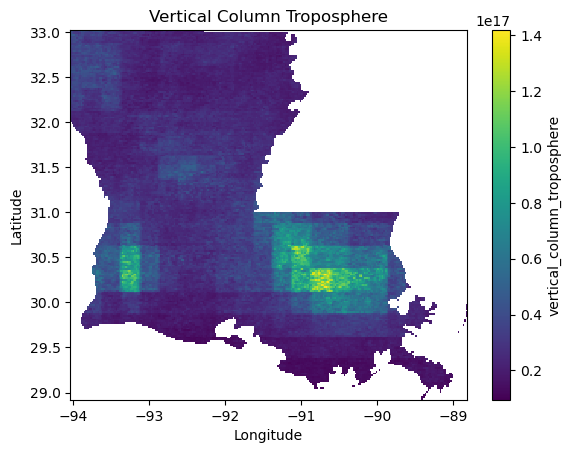

In [10]:
import matplotlib.pyplot as plt

# If your variable has a time dimension, pick one time slice, e.g., first time:
# data = combined_data['vertical_column_troposphere'].isel(time=1)
data = percentile_98
# Plot with xarray's built-in plot, passing cmap here:
data.plot(cmap='viridis')

plt.title('Vertical Column Troposphere')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
